# MATH80629
# Semaine \#3 - Apprentissage supervisé - Exercices

Ce tutoriel explore des modèles d'apprentissage automatique pour la classification. C'est à dire quand la variable cible est une variable catégorielle.

In [1]:
import pandas as pd
import numpy as np   
import matplotlib.pyplot as plt
import sklearn as sk
%matplotlib inline
from sklearn.datasets import make_classification

# Code to obtain utils.py
#!rm -rf 80-629
#!git clone https://github.com/lcharlin/80-629/
#import sys
#sys.path += ['80-629/week3-Supervised/']

from utils import generate_data, plot_predictions, plot_svc_decision_function

### Commençons par générer trois jeux de données

Nous utiliserons 3 jeux de données pour la classification binaire. 

Chaque jeu contient un ensemble d'entraînement et un de test. De plus, chaque jeu de données a été généré par une processus génératif distinct. Cette diversité, nous permettra d'explorer les proprietés des modèles de classification.

Pour l'instant, vous pouvez comparer les jeux de données visuellement. 

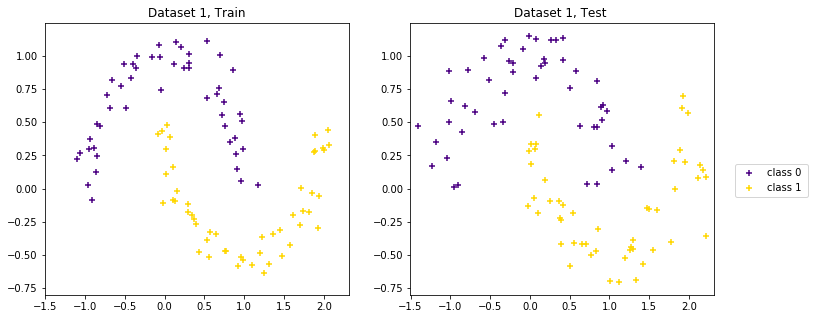

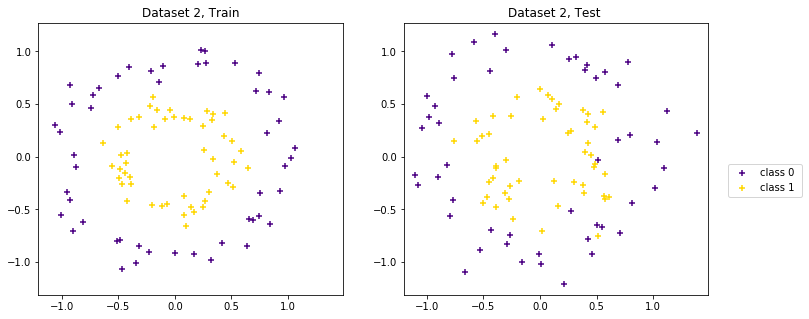

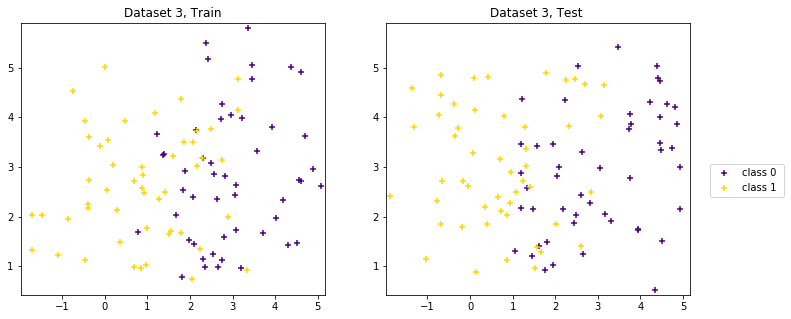

In [2]:
datasets_train, datasets_test = generate_data()

for i, (ds_train, ds_test) in enumerate(zip(datasets_train, datasets_test)):
    ds_train = datasets_train[i]
    ds_test = datasets_test[i]

    X = ds_train[0]
    Y = ds_train[1]
    
    X_test = ds_test[0]
    Y_test = ds_test[1]

    plot_predictions(i+1, X, Y, X_test, Y_test, pred_train=Y, pred_test=Y_test )

## 1. Classification avec un modèle linéaire

### 1.1. Classification binaire à partir d'un modèle de régression linéaire

La semaine dernière, les exercices ont porté sur les modèles de régression linéaire appris en minimisant l'erreur quadratique moyenne. Dans ce cas, nous pouvions estimer les paramètres de manière analytique (par exemple la diapo 31 de la deuxième semaine).

Dans un contexte de classification, et comme discuté dans les capsules, nous pouvons ajouter une règle de décision en plus du (ou après le) modèle de régression qui permettra de classifier les valeurs prédites (*réelle*) dans une classe ou une autre (*binaire*).

Nous exprimons la règle de décision sous la forme $sign(y(x))$, où $y(x) = W^\top x$ est notre modèle. 

Nous définissons: 

$$ sign(a) = \left\{\begin{array}{} 
+1, &\text{si } a > 0\\
-1, &\text{sinon}
\end{array}\right. $$

Donc, cette règle de décision définie implicitement une frontière de décision. Du côté $a>0$ les points appartiennent à une classe ($+1$) et de l'autre côté ($a\leq 0$) à la seconde classe ($-1$).

Implémentons un classificateur en utilisant ce modèle avec une règle de décision.

In [65]:
# Modèle linéaire pour classification binaire
def OLS(X, y):
    # Note: on transforme simplement les cibles de {0,1} à {-1,+1}
    Y = (ds_train[1]*2)-1
    Y = Y.reshape(100,1)

    # On calcule les paramètres du modèle
    # (c'est le même calcul que celui de la semaine dernière pour w_ols)
    A = np.linalg.inv(np.dot(X.T, X))
    B = np.dot(X.T, Y)
    
    return np.dot(A, B)

# pour obtenir la frontière de décision visuellement
def calculate_decision_boundary(W):
    x_1 = np.linspace(-10,10) # <- pour x1;
    
    # Le but est donc de calculer x2 à partir de x1 et des poids.
    x_2 = (-W[0] - W[1]*x_1) / W[2]
    return x_1, x_2

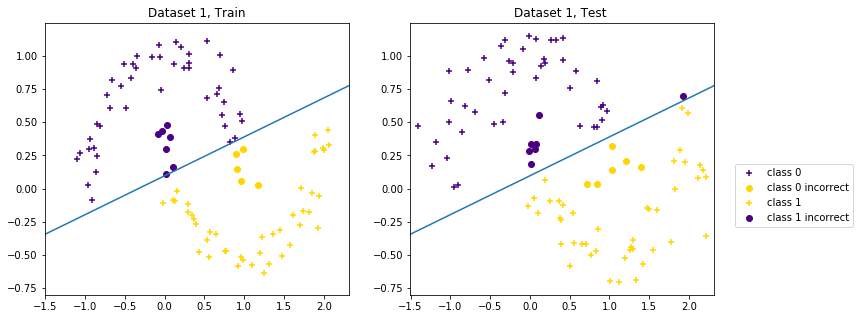

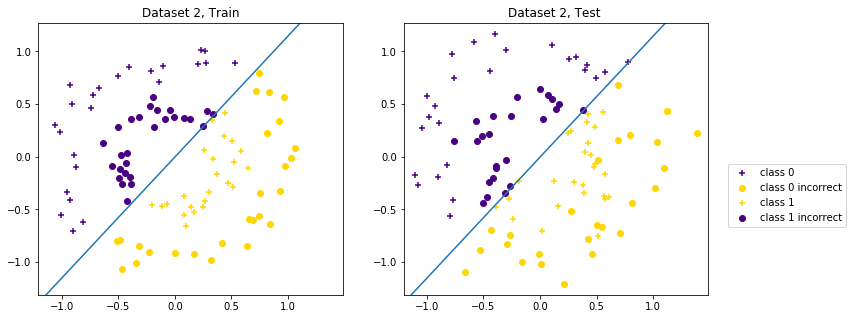

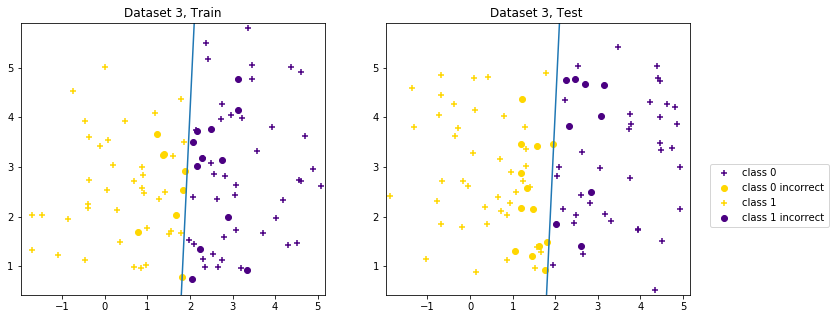

In [66]:
for i, (ds_train, ds_test) in enumerate(zip(datasets_train, datasets_test)):
    ds_train = datasets_train[i]
    ds_test = datasets_test[i]

    X = ds_train[0]
    
    # On ajoute une colonne de 1 aux données
    # Ça nous permet d'apprendre le biais (w0 dans: w_1x + w0)
    X_b = np.array([np.ones(len(X)), X[:,0], X[:,1]]).T
    ####
    
    Y = ds_train[1]
    X_test = ds_test[0]

    # Comme plus haut on ajoute une colonne de 1 aux données de test
    X_test_b = np.array([np.ones(len(X_test)), X_test[:,0], X_test[:,1]]).T
    ###

    Y_test = ds_test[1]

    # 1) On (estime) entraîne les paramètres
    # k est le nombre de classes et dim est la dimensionalité des données 
    W = OLS(X_b, Y) # dim x k

    # 2) Une fois les paramètres obtenus, on peut obtenir les prédictions 
    # a) for test data
    y_x = np.dot(W.T, X_test_b.T) # valeur réelle
    pred_test = 1*(y_x>0)[0] # valeur binaire

    # b) Idem pour l'ensemble d'entraînement
    y_x = np.dot(W.T, X_b.T)
    pred_train = 1*(y_x>0)[0]

    
    # 3) On calcule aussi la frontière de décision 
    #    pour pouvoir la visualiser
    line_x, line_y = calculate_decision_boundary(W)
    
    
    # 4) Rendu visuel
    plot_predictions(i+1 ,X,Y, X_test, Y_test, pred_train, pred_test, line_x, line_y)

**Question 1 (Classification linéaire):** pour lequel des jeux de données le modèle atteint-il la meilleure performance? Expliquez en vos mots.

### 1.2. Machine à support de vecteurs (*Support Vector Machine (SVM)*)

Pour entraîner et évaluer un SVM, un modèle introduit brièvement dans les capsules, nous utiliserons la libraire sklearn.

Pour commencer, nous allons générer des données linéairement séparables.

(-0.5, 2.2)

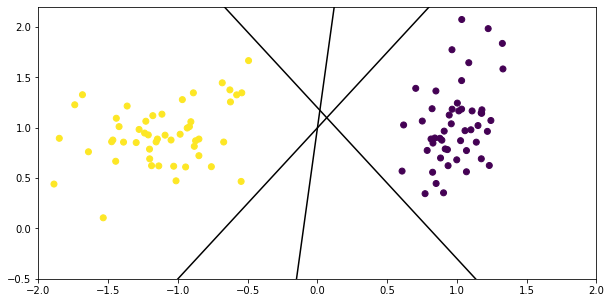

In [67]:
# let's load a linearly separable dataset
X_l,Y_l = make_classification(n_features=2, n_redundant=0, n_informative=2,
                               random_state=1, n_clusters_per_class=1)
fig = plt.figure(figsize = (10,5))
xfit = np.linspace(-2, 2)
plt.scatter(X_l[:, 0], X_l[:, 1], c=Y_l)

for m, b, d in [(1.5, 1, 0.2), (10, 1, 2), (-1.5, 1.2, 0.2)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, '-k')
    #plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none',
    #                 color='#AAAAAA', alpha=0.4)
plt.xlim(-2,2)
plt.ylim(-0.5,2.2)

Dans la figure ci-haut, nous remarquons qu'il y a plusieurs frontières de décision qui peuvent parfaitement séparer les deux classes (jaune et mauve). Il y en a en fait une infinité. 

Un SVM choisit la frontière de décision qui maximise la marge. C'est-à-dire la distance entre la frontière de décision et les points de chaque classe les plus proches. 

Pour pouvoir visualiser ce concept, nous allons maintenant entraîner un modèle SVM.

In [11]:
# on commence par ajouter le classificateur SVM
from sklearn.svm import SVC 
model = SVC(kernel='linear', C=1E10)

# Avec la fonction fit(), on entraîne le modèle (on apprend ses paramètres)
model.fit(X_l, Y_l)

SVC(C=10000000000.0, break_ties=False, cache_size=200, class_weight=None,
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma='scale',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

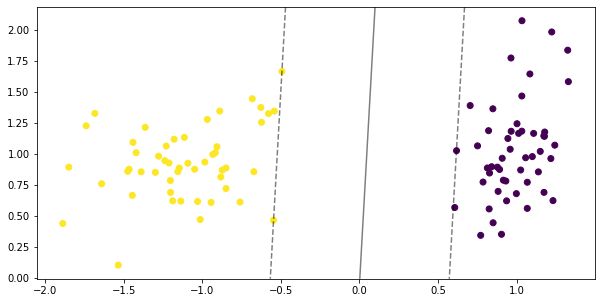

In [12]:
fig = plt.figure(figsize = (10,5))
ax = fig.add_subplot(111)
im =ax.scatter(X_l[:, 0], X_l[:, 1], c = Y_l)
ax = plot_svc_decision_function(model,ax)

Dans la figure ci-haut, on voit que le SVM a choisit la frontière de décision (ligne pleine) qui maximise la marge (la distance entre la ligne pleine et chacune des lignes en pointillé). 

De plus, les points qui touchent aux lignes en pointilée sont appelés vecteurs de support (support vectors).

Maintenant que nous avons revu la base des SVM, on peut utiliser un SVM pour classifier le jeu de données #3 (celui sur lequel notre modèle linéaire initial fonctionnait le mieux et qui est le mieux « adapté » aux modèles linéaires).

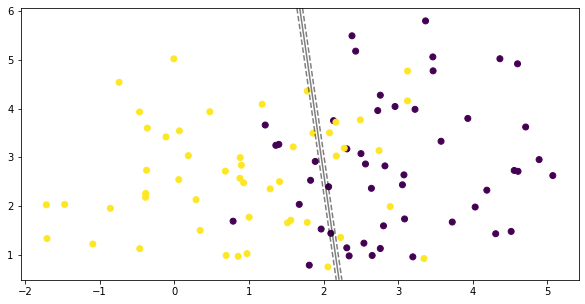

In [13]:
X, Y = datasets_train[2]
X_test, Y_test = datasets_test[2]

# On commence par définir le SVM 
model = SVC(kernel='linear', C=10e6)

# Puis on entraîne ses paramètres avec la fonction fit()
model.fit(X, Y)

fig = plt.figure(figsize = (10,5))
ax = fig.add_subplot(111)

plt.scatter(X[:, 0], X[:, 1], c=Y)
plot_svc_decision_function(model,ax)

À la prochaine nous obtenons la performance du SVM sur l'ensemble d'entraînement et de test. 

(Pour mieux comprendre, vous pouvez voir la documention (en anglais) du classificateur SVM [ici](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html). Nous y reviendrons à la semaine #4.)

In [14]:
acc_train = (sum(model.predict(X)==Y)/len(Y))*100 #QUESTION - complétez ces deux lignes
acc_test =  (sum(model.predict(X_test)==Y_test)/len(Y_test)) *100 

print("Accuracy train: ", acc_train, "%")
print("Accuracy test: ",  acc_test, "%")

Accuracy train:  79.0 %
Accuracy test:  79.0 %


On note que notre jeu de données n'est pas séparable linéairement, c'est-à-dire que les deux classes se chevauchent et il n'existe pas une frontière de décision linéaire qui permet de parfaitement les séparer. 

Bien que les SVM aient une assise théorique, ici nous essaierons plutôt de raffiner notre intuition sur ce modèle. 

Le SVM tente de maximiser la marge tout en minimisant l'erreur d'entraînement. Dans le cas de jeux de données non séparables linéairement, ces deux objectifs peuvent être contradictoires.

Pour calibrer les deux objectifs, les SVM utilisent un hyperparamètre (dans sklearn il est dénoté par la lettre 'C').

Tel que vu la semaine dernière, en apprentissage automatique, il est important de trouver les bonnes valeurs à un hyper paramètre. 

**Question 2 (SVM):** en vous référant à la documentation des SVM [ici (en anglais)](https://scikit-learn.org/stable/modules/svm.html#svc) trouvez l'hyperparamètre qui contrôle la régularisation et changer le pour obtenir une marge plus « soft ». Vous pouvez ensuite mesurer la performance de votre modèle. Y'a-t-il des gains?

Accuracy train:  79.0 %
Accuracy test:  79.0 %


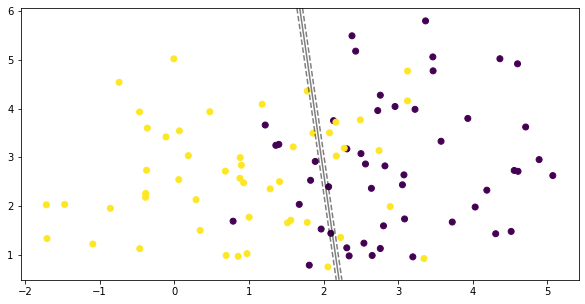

In [40]:
X, Y = datasets_train[2]
X_test, Y_test = datasets_test[2]

# nous créons un modèle de classification SVM 
model = SVC(kernel='linear', C=10e6)

# nous apprenons ses paramètres.
model.fit(X, Y)


fig = plt.figure(figsize = (10,5))
ax = fig.add_subplot(111)

plt.scatter(X[:, 0], X[:, 1], c=Y)
plot_svc_decision_function(model,ax)

acc_train = (sum(model.predict(X)==Y)/len(Y))*100
acc_test =  (sum(model.predict(X_test)==Y_test)/len(Y_test)) *100 

print("Accuracy train: ", acc_train, "%")
print("Accuracy test: ",  acc_test, "%")

Maintenant, entraînons un modèle SVM sur nos trois jeux de données 

(*Note: on vous suggère de complétez la question précédente avant de lancer la prochaine cellule qui pourrait sinon prendre beaucoup de temps à se terminer.*)

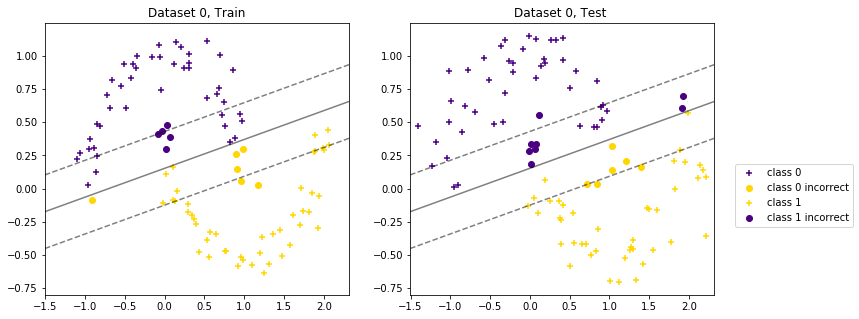

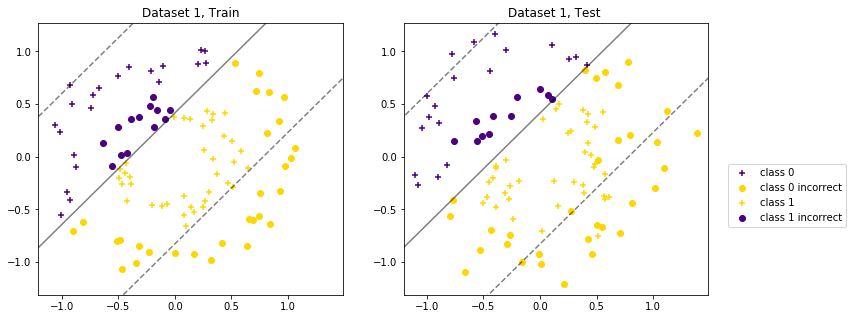

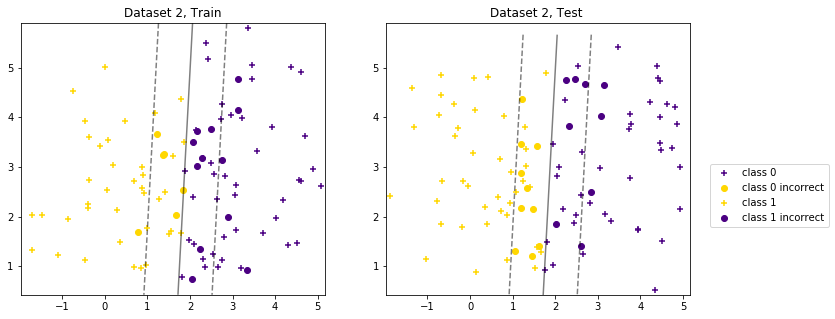

In [16]:
for i, (ds_train, ds_test) in enumerate(zip(datasets_train, datasets_test)):
    ds_train = datasets_train[i]
    ds_test = datasets_test[i]

    X = ds_train[0]
    Y = ds_train[1]
    
        
    X_test = ds_test[0]
    Y_test = ds_test[1]
    # 1) on entraîne les paramètres
    model.fit(X, Y)

    # 2) On obtient les prédictions
    # a) pour l'ensemble de test
    pred_test = model.predict(X_test)

    # b) pour l'ensemble d'entraînement
    y_x = np.dot(W.T, X_b.T)
    pred_train = model.predict(X)
    
    # 3) visualisons les résultats
    plot_predictions(i,X,Y, X_test, Y_test, pred_train, pred_test, plot_svm=model)

## 2. Modèles probabilistes

### 2.1. Modèle Bayesian Naïf (Naive Bayes)

Pour l'instant, nous avons exploré des modèles linéaires pour la classification (pour rappel, un modèle est linéaire si ça frontière de décision est linéaire)

Maintenant, nous explorerons un modèle de classification Naive Bayes. Le modèle a été introduit dans les capsules et nous verrons qu'il peut apprendre une frontière de décision non linéaire.

De plus, le modèle Naive Bayes est un modèle probabiliste. Entre autres, il assignera donc une probabilité à ses prédictions (par exemple le modèle pourrait prédire qu'un point fait partie de la classe +1 à 70%) plutôt que seulement en prédire la classe.

Dans nos trois jeux de données synthétiques, la variable cible a deux valeurs possibles$y \in \{0,1 \}$ (ou de manière équivalente -1 et +1). 

La variable cible est donc une variable binaire que l'on peut modéliser avec une distribution de *Bernoulli*
$$P(y=k ;\pi) = \pi^k(1-\pi)^{1-k}.$$

Les variables indépendantes $x \in \mathbb{R}^2$ sont des variables continues. Comme discuté dans les capsules, nous pouvons donc les modéliser avec une distribution gaussienne 
$$P(x; \mu, \sigma) = \mathcal{N}(x_j | \mu_{jk}, \sigma^2_{jk}).$$

En modélisant les variables cibles et indépendantes avec ces distributions le problème sera donc d'évaluer les paramètres de ces distributions:
- la probabilité d'un succès $p_k$ pour la Bernoulli et 
- le vecteur des moyennes $\mu$ et les variances $\sigma^2$ pour la Gaussienne.



La procédure pour apprendre le classificateur Naive Bayes est décrite ci-dessous. 
    
   1. Calculer estimateur du maximum de vraisemblance (*MLE*) pour les paramètres de la distribution :  
     $\theta \in \{$<font size="2" color='red'> $  \sigma^2_{jk}, \mu_{jk}, \pi   $ </font> \} en utilisant l'ensemble d'entraînement.
   2. Utilisez les paramètres estimés avec la formule de <font size="2" color='red'> Bayes  </font> pour obtenir des prédictions : 
   
   $posterior  \propto joint \space distribution = class\space conditional * class\space prior$
   
   $P(y = k|x) \propto$  <font size="2" color='red'> P(y = k, x) = P(x | y = k) P(y)  </font>.

Nous allons maintenant implémenter un modèle NB pour nos trois jeux de données synthétiques.


Commençons par préparer nos données.

In [69]:
# on utilise le jeu de données qui contient 
# les deux cercles concentriques
X, Y = datasets_train[1] 
X_test, Y_test = datasets_test[1] # idem pour le test

# le code suivant 
# on veut obtenir une structure qui nous indique quelles sont les données
# qui appartiennent à chacune des classes

#class indices
i_c0 = (Y == 0)
i_c1 = (Y == 1)

X_0 = X[i_c0] #data of class 0
X_1 = X[i_c1] #data of class 1

### 2.1.1 Entraîner le modèle (vous pouvez sauter jusqu'à 2.2 s'il manque de temps)

Rappel: Pour entraîner le modèle Naive Bayes, il nous faut trouver 1) les prieurs (*class prior*), 2) les probabilités conditionnelles par classe (*class conditional*), 3) combiner les deux termes pour obtenir le postérieur sur y. 



#### Les prieurs

On débute en calculant les prieurs (prior probability) pour chacune des classes. L'estimateur de maximum de vraisemblance (maximum likelihood estimate ou MLE en anglais) d'une variable aléatoire avec une distribution Bernoulli est simplement sa moyenne échantillonnale:
\begin{align}
    \hat{\pi} = \frac{\sum_{i=0}^n y_i}{n}, 
\end{align}
avec $n$ le nombre d'observations dans notre ensemble d'entraînement.

**Question 3 (NB):** À partir de l'équation ci-haut, écrivez le code pour estimer $\hat{\pi}_1$ pour la classe 1 (variable `prior_k1` dans le code) et $\hat{\pi}_0$ pour la classe 0 (variable `prior_k0`). 

Attention, pour $\hat{\pi}_0$ il ne faut utiliser que les données de la classe 0 (et idem pour la classe 1).

In [18]:
def calculate_prios(X_0, X_1, Y):
    # À faire: calculez la prieur pour la classe 1
    prior_k1 = sum(Y) / len(Y) #QUESTION
    
    # À faire: calculez la prieur pour la classe 0 
    prior_k0 = 1 - prior_k1 #QUESTION 

    #let's store the priors in a dictionary
    prior_dict = {"class 0":prior_k0 , "class 1":prior_k1  }
    
    return prior_dict

In [19]:
print(Y)

[1 1 0 1 1 0 0 1 1 1 1 0 1 1 1 0 0 0 1 0 0 1 1 1 0 0 1 0 0 0 1 1 1 1 1 0 0
 1 0 0 1 1 1 0 1 0 0 1 0 1 0 1 0 0 1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 1 0 1 1
 0 1 0 1 1 0 0 0 0 0 0 1 0 0 1 1 0 0 1 1 0 1 0 1 0 0]


In [20]:
prior_dict = calculate_prios(X_0, X_1, Y)
print(prior_dict)

{'class 0': 0.5, 'class 1': 0.5}


Maintenant que nous avons les prieurs, il faut trouver les paramètres de la Gaussienne des probabilités conditionnelles de classe. 

(*Remarque:* même si la Gaussienne n'est qu'un terme d'un modèle complet (NB), on optimise en général le log de la vraisemblance ce qui a pour effet de séparer les termes de l'objectif et donc pour optimiser les termes de la Gausienne nous pouvons utiliser les estimateurs de maximum de vraisemblance (MLE). 

Comme expliqué [ici (en anglais)](https://www.statlect.com/fundamentals-of-statistics/normal-distribution-maximum-likelihood), la MLE de la **moyenne** d'une Gaussienne est simplement la moyenne échantillonnale:

$\hat{\mu} = \frac{1}{n} \sum_{i=0}^{n} x^{(i)}$. Pour notre algorithme, il faudra calculer cette quantité pour chaque classe ($k$) et pour chaque caractéristique ($j$):
\begin{align}
    \hat{\mu}_{jk} = \frac{\sum_{i=0}^{n} \mathbb{1}(y^{(i)}=k) x_{j}^{(i)}}{ \sum_{i=0}^{n} \mathbb{1}(y^{(i)}=k)} 
\end{align}
(*Notez, $\mathbb{1}(y^{(i)}=k)$ vaut 1 quand $y^{(i)}=k$ et 0 sinon.*)


De plus, la MLE de la *variance* d'une Gaussienne est simplement la variance échantillonnale: 

$$\hat{\sigma}^2 = \frac{1}{n} \sum_{j=0}^{n} (x^{(j)} - \mu)^2$$

(*Comme pour la moyenne, il faut calculer la variance par classe et par caractéristique de x.*)


**Question 4 (NB)**: completez l'implémentation des estimés MLE:

In [21]:
def calculate_MLE(X_0,X_1):

    # Calculez les statistiques pour chaque classe et caractéristique
    class_summaries = dict()

    feat_0_class_0 = np.mean(X_0[:,0]), np.std(X_0[:,0])
    feat_1_class_0 = np.mean(X_0[:,1]), np.std(X_0[:,1])

    # les ajouter au dictionnaire
    class_summaries['class 0'] = [feat_0_class_0, feat_1_class_0]

    feat_0_class_1 = np.mean(X_1[:,0]), np.std(X_1[:,0]) #QUESTION <- à compléter (classe 1 caractéristique 0)
    feat_1_class_1 = np.mean(X_1[:,1]), np.std(X_1[:,1]) #QUESTION <- à compléter (classe 1 caractéristique 1)
    
    # les ajouter au dictionnaire 
    class_summaries['class 1'] = [feat_0_class_1, feat_1_class_1]
    return class_summaries

In [22]:
class_summaries = calculate_MLE(X_0, X_1)

# on visualise les résultats
for c, class_summary in class_summaries.items():
    print(c)
    print(class_summary)

class 0
[(-0.007192166649648344, 0.704420431973722), (-0.008230521965483994, 0.6846599657190768)]
class 1
[(-0.003679746221999508, 0.36171707161392364), (-0.011058582492496059, 0.3425693756367293)]


Pour résumer&nbsp;:

- Notre dictionnaire `class_summaries` (voir ci-haut) contient une liste avec les moyennes et variances échantillonnales pour chaque classe et chaque caractéristique.

- Notre dictionnaire `prior_dict` contient les prieurs pour chaque classe.

Voilà, nous avons terminé d'entraîner le classificateur Naive Bayes!



### 2.1.2 Tester notre modèle

Puisque nous posé comme hypothèse que les caractéristiques ($x$) viennent d'une distribution gaussienne, nous devons implémenter la fonction de densité (PDF) de la gaussienne. Cette fonction retournera la `fréquence relative` d'une donnée étant donnée les paramètres de la gaussienne ($\mu, \sigma^2$): 
$$ \mathcal{N}(x,\mu,\sigma) = \frac{1}{ \sigma \sqrt{2 \pi}} e^{\left(-\frac{{\left(\mu - x\right)}^{2}}{2 \, \sigma^{2}}\right)} $$

In [23]:
def Gaussian_PDF(x, mean, stdev):
    exponent = np.exp(-((x-mean)**2 / (2 * stdev**2 )))
    return (1 / (np.sqrt(2 * np.pi) * stdev)) * exponent

Nous pouvons obtenir les prédictions de notre modèle.

*Rappel:* il suffit d'utiliser la formule de Bayes.

In [24]:
# une donnée (de test)
test_point = X_test[2]
print('test point: ', test_point)
print(f'value of feature 1: {test_point[0]}, value of feature 2: {test_point[1]}')

test point:  [ 0.7078584 -0.721475 ]
value of feature 1: 0.7078584041289085, value of feature 2: -0.721474995667992


**Question 5 (NB):** complétez la fonction ci-dessous pour calculer la probabilité postérieure d'une donnée de test.

In [25]:
def calculate_probability(x_test, class_summaries, prior_dict):
    # nous allons conserver les probabilités prédites 
    # dans ce dictionnaire
    resulting_probabilities = dict() 
    
    
    for c, class_stats in class_summaries.items():

        prior_c = prior_dict[c]
        # put P(y) in the dictionary containing the result
        resulting_probabilities[c] = prior_c 

        for i, feature_stat in enumerate(class_stats):
            mean, stdev = feature_stat
            #À faire: <- complétez la ligne ci-dessous, pour obtenir la probabilité postérieur
            #           d'une donnée de test.
            resulting_probabilities[c] *= Gaussian_PDF(x_test[i], mean, stdev)     
    return resulting_probabilities
        
    

In [26]:
print(test_point)
probs = calculate_probability(test_point, class_summaries, prior_dict)
print(probs)

[ 0.7078584 -0.721475 ]
{'class 0': 0.05728953380422133, 'class 1': 0.010803175622848884}


`probs` est un dictionnaire qui contient des quantités proportionnelles à la probabilité postérieure de chaque classe pour chaque donnée. 

Notre fonction de décision sera simplement de prédire la classe avec la probabilité la plus élevée.


**Question 6 (NB)**: pourquoi dit-on que le modèle NB est naïf? Référrez-vous au code de la fonction `calculate_probability` qui implémentante l'hypothèse naïve.

**Réponse**: la ligne  14 dans la fonction `calculate_probability`   (*resulting_probabilities[c] *= Gaussian_PDF(x_test[i], mean, stdev)*), 
implémente l'hypothèse que les caractéristiques sont indépendantes étant donnée la classe. 

**(Bonus) Question 6 (NB)**: Pourquoi les supposées probabilités du modèle NB ne sont pas normalisées?

Indice: voir la formule pour calculer les postérieurs au début de la section.

**Réponse**: Nous utilisons des postérieurs non-normalisées pour calculer les postérieurs.

### 2.2 Utilisation du modèle NB

Nous pouvons maintenant utiliser notre modèle NB sur nos trois jeux de données:

In [27]:
def train_NB(X,Y):
    #class indices
    i_c0 = (Y == 0)
    i_c1 = (Y == 1)

    X_0 = X[i_c0] # données pour classe 0
    X_1 = X[i_c1] # données pour classe 1
    
    prior_dict = calculate_prios(X_0, X_1, Y)
    
    # Calcul des statistiques pour 
    # chaque classe et chaque caractéristique 
    class_summaries = calculate_MLE(X_0,X_1)
    
    return prior_dict, class_summaries


def test_NB(X, class_summaries, prior_dict):
    result = []
    for x_test in X:
        probs = calculate_probability(x_test, class_summaries, prior_dict)
        result.append(list(probs.values()))
    return np.array(result)
    
    

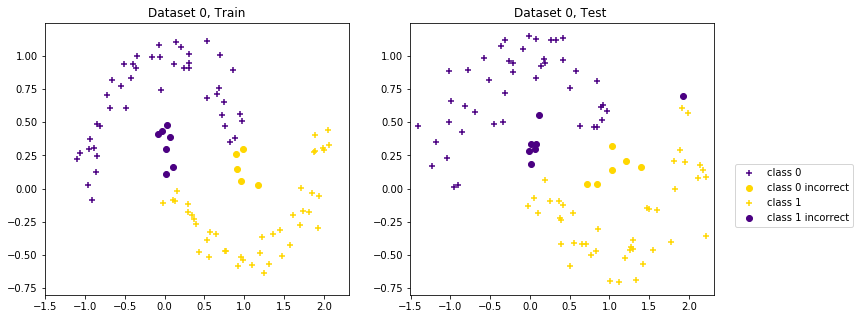

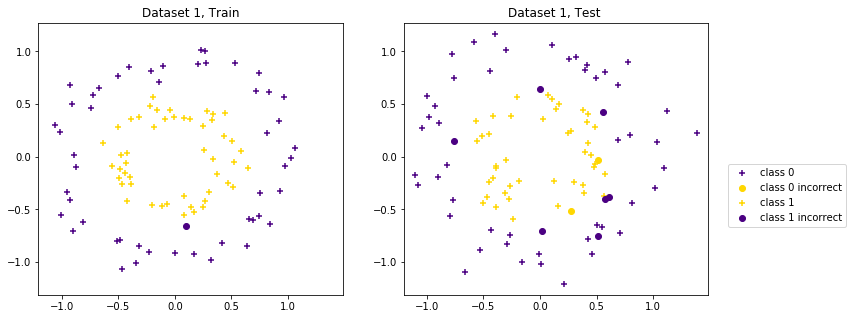

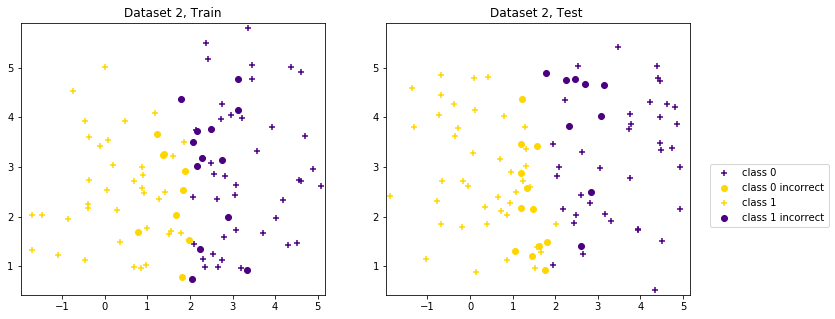

In [28]:
for i, (ds_train, ds_test) in enumerate(zip(datasets_train, datasets_test)):
    ds_train = datasets_train[i]
    ds_test = datasets_test[i]

    X = ds_train[0]
    Y = ds_train[1]    
        
    X_test = ds_test[0]
    Y_test = ds_test[1]
    # 1) entraîner le modèle
    prior_dict, class_summaries = train_NB(X,Y)
    
    # 2) Prédire
    # a) pour les données test
    posterior = test_NB(X_test, class_summaries, prior_dict)
    pred_test = np.argmax(posterior,1)

    # b) pour les données d'entraînement
    posterior = test_NB(X, class_summaries, prior_dict)
    pred_train = np.argmax(posterior,1)
    
    #4) Pour la visualsation
    i_c0 = (Y == 0)
    i_c1 = (Y == 1)
    
    # TRAIN: obtenir les vrais et faux positifs.
    i_c0_t = (pred_train[i_c0]==0); i_c0_f = (pred_train[i_c0]==1)
    i_c1_t = (pred_train[i_c1]==1); i_c1_f = (pred_train[i_c1]==0)
    
    plot_predictions(i,X,Y, X_test, Y_test, pred_train, pred_test)

**Question 7 (NB):** Pour quel(s) jeu(x) de données le classificateur NB a-t-il le mieux performé? Comment en venez-vous à cette conclusion? 

Pourquoi semble-t-il moins bien modéliser les données du premier jeu de données?

**Réponse possible**: Il a le mieux fonctionné pour les jeux de données 2 et 3. Pour ces jeux de données, les probabilités conditionnelles des classes en fonction des caractéristiques peuvent en effet être modélisées avec une distribution gaussienne. 

Par contre, pour le premier jeu de données (les deux lunes) ce n'est pas le cas.

En pratique, vous ne voudrez sans doute pas réimplémenter le modèle NB pour chaque type de variable cible ou caractéristique. La libraire `sklearn` a une implémentation du modèle NB. Essayons là. 

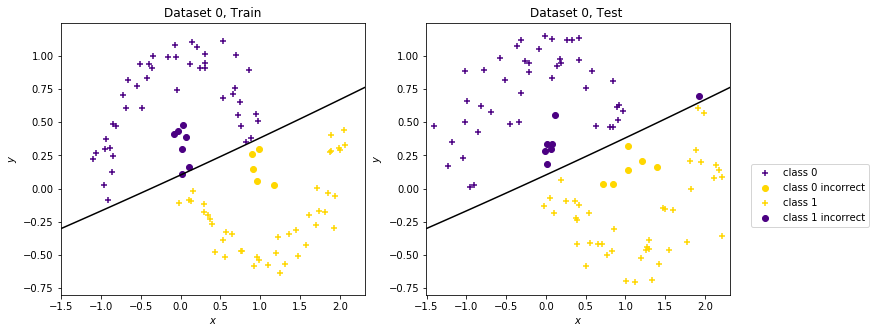

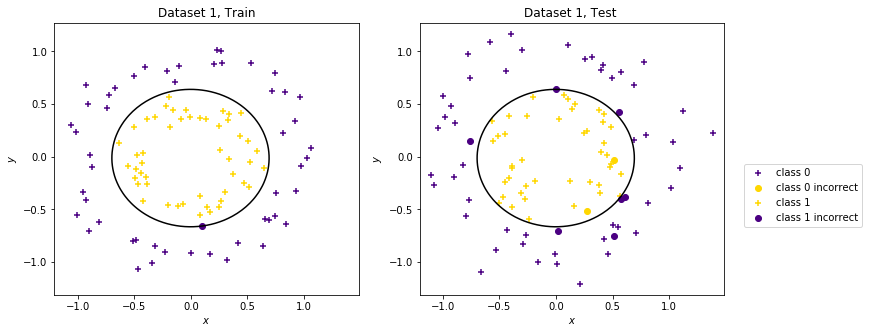

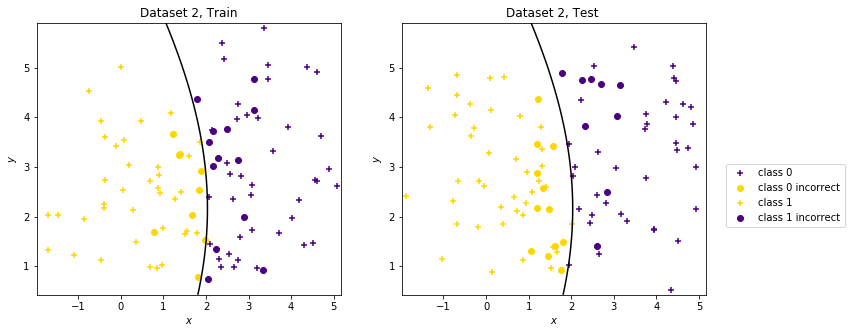

In [29]:
from sklearn.naive_bayes import GaussianNB

for i, (ds_train, ds_test) in enumerate(zip(datasets_train, datasets_test)):
    ds_train = datasets_train[i]
    ds_test = datasets_test[i]

    X = ds_train[0]
    Y = ds_train[1]
    
        
    X_test = ds_test[0]
    Y_test = ds_test[1]
    # 1) Instancions le modèle 
    #   avec les probabilités conditionnelles gaussiennes
    model = GaussianNB()
    # on apprend les paramètres du modèle sur les données d'entraînement 
    model.fit(X, Y)

    # 2) On peut utiliser le modèle pour obtenir des prédictions sur
    #   a) sur les données de test
    pred_test = model.predict(X_test)

    #   b) sur les données d'entraînement 
    y_x = np.dot(W.T, X_b.T)
    pred_train = model.predict(X)

    
    # 4) on visualise les prédictions ainsi que la frontière de décision.
    plot_predictions(i,X,Y, X_test, Y_test, pred_train, pred_test,  plot_nb=model )

### 2.3. Les modèles NB pour la classification de texte

Après cet aperçu des modèles NB, nous explorons leur application pour la classification de documents.

Cet exemple vient du livre [Python Data Science Handbook](https://www.oreilly.com/library/view/python-data-science/9781491912126/).

Comme nous l'avons abordé dans les capsules, en classification de texte, les caractéristiques de chaque document sont le nombre d'occurrences de chaque mot.

Nous commençons pas télécharger un jeu de données contenant en ensemble de documents. (Ce jeu de données `20newsgroup` est standard en apprentissage automatique). Chaque document est associé à une classe qui correspond au thème du document. 

Les 20 cibles/thèmes possibles sont ci-bas:

In [30]:
from sklearn.datasets import fetch_20newsgroups

data = fetch_20newsgroups()
data.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

Pour simplifier les choses, nous allons garder que les documents associés à quatre de ces catégories.

In [31]:
categories = ['talk.religion.misc', 'soc.religion.christian',
              'sci.space', 'comp.graphics']
train = fetch_20newsgroups(subset='train', categories=categories)
test = fetch_20newsgroups(subset='test', categories=categories)

Voici un exemple d'un document (chaque document est un courriel qui a été envoyé sur une liste de diffusion associée à un thème): 

In [32]:
print(train.data[5])

From: dmcgee@uluhe.soest.hawaii.edu (Don McGee)
Subject: Federal Hearing
Originator: dmcgee@uluhe
Organization: School of Ocean and Earth Science and Technology
Distribution: usa
Lines: 10


Fact or rumor....?  Madalyn Murray O'Hare an atheist who eliminated the
use of the bible reading and prayer in public schools 15 years ago is now
going to appear before the FCC with a petition to stop the reading of the
Gospel on the airways of America.  And she is also campaigning to remove
Christmas programs, songs, etc from the public schools.  If it is true
then mail to Federal Communications Commission 1919 H Street Washington DC
20054 expressing your opposition to her request.  Reference Petition number

2493.



Nous pouvons convertir, chaque document en vecteur de chiffres en utilisant l'encodage [TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf). 

Ensuite nous créons un `pipeline` pour utiliser un modèle de classification **Naive Bayes multinomial**.

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline

model = make_pipeline(TfidfVectorizer(), MultinomialNB())

On peut entraîner le modèle sur les données d'entraînement et prédire les cibles des données de test: 

In [34]:
model.fit(train.data, train.target)
labels = model.predict(test.data)

On évalue ensuite la performance du modèle. 

Pour commencer, nous utiliserons une [matrice de confusion](https://fr.wikipedia.org/wiki/Matrice_de_confusion)&nbsp;:

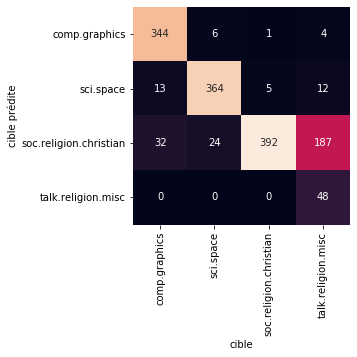

In [35]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(test.target, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=train.target_names, yticklabels=train.target_names)
plt.xlabel('cible')
plt.ylabel('cible prédite');

Nous observons que le classificateur arrive à bien départager les documents traîtant de l'informatique (`comp.graphics`) de ceux traîtants de l'expsace (`sci.space`). Mais le classificateur a plus de difficulté quand il s'agit des documents des deux autres catégories (`soc.religion.christian` et `talk.religion.misc`) qui semblent en effet plus similaires.

Nous pouvons de plus classifier n'importe quel nouveau document aussi court soit-il, en utilisant la fonction ``predict()``.

Pour simplifier davantage les choses, voici une courte fonction qui retourne la prédiction la plus probable d'un document donnée en entrée:

In [36]:
def predict_category(s, train=train, model=model):
    pred = model.predict([s])
    return train.target_names[pred[0]]

In [37]:
predict_category('sending a payload to the ISS')

'sci.space'

In [38]:
predict_category('discussing islam vs atheism')

'soc.religion.christian'

In [39]:
predict_category('determining the screen resolution')

'comp.graphics'

N'oubliez pas qu'il ne s'agit que d'un modèle probabiliste relativement simple qui utilise les fréquences de chaque mot dans un document. Néanmoins, les résultats sont intéressants. 

Conclusion, même un algorithme relativement simple (et naïf!), entraîné sur pas mal de données, peut obtenir des résultats impressionnants.